In [1]:
from discopy import Ty, Word

s, n = Ty('s'), Ty('n')
Alice, loves, Bob = Word('Alice', n), Word('loves', n.r @ s @ n.l), Word('Bob', n)

print("Vocabulary:\n{}".format('\n'.join(map(repr, [Alice, loves, Bob]))))

Vocabulary:
Word('Alice', Ty('n'))
Word('loves', Ty(Ob('n', z=1), 's', Ob('n', z=-1)))
Word('Bob', Ty('n'))


Diagram for 'Alice loves Bob':


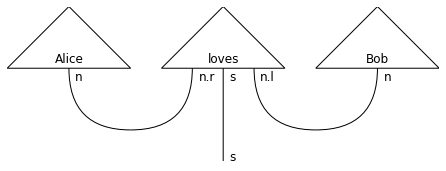

In [2]:
from discopy import Diagram, Id, Box, Cup, Cap
from discopy.grammar import draw

grammar = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

sentences = {"{} {} {}.".format(subj, verb, obj): subj @ verb @ obj >> grammar
             for subj in [Alice, Bob] for verb in [loves] for obj in [Alice, Bob]}

print("Diagram for 'Alice loves Bob':")
draw(sentences["Alice loves Bob."], draw_types=True)

Diagram for 'Alice loves Bob', with snakes removed:


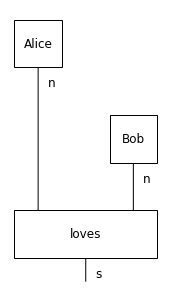

In [4]:
from discopy import Functor

love_box = Box('loves', n @ n, s)
love_ansatz = Cap(n.r, n) @ Cap(n, n.l) >> Id(n.r) @ love_box @ Id(n.l)

A = Functor(
    ob={s: s, n: n},
    ar={Alice: Alice, Bob: Bob, loves: love_ansatz})

diagrams = {string: A(sentence).normal_form() for string, sentence in sentences.items()}

print("Diagram for 'Alice loves Bob', with snakes removed:")
diagrams["Alice loves Bob."].draw()

In [5]:
sentences = list(sentences.keys())
print("Grammatical sentences:\n{}".format('\n'.join(sentences)))

Grammatical sentences:
Alice loves Alice.
Alice loves Bob.
Bob loves Alice.
Bob loves Bob.


In [10]:
from discopy.quantum import Ket, H, Rx, CX, sqrt, Measure, CGate

def verb_ansatz(params):
    phase, *weights = params
    return CX >> sqrt(2) @ H @ Rx(phase)\
        >> Measure(2) >> CGate("weights", 2, 0, weights)

params0 = [0.5, 1, 0, 0, 0]

Circuit for 'Alice loves Bob':


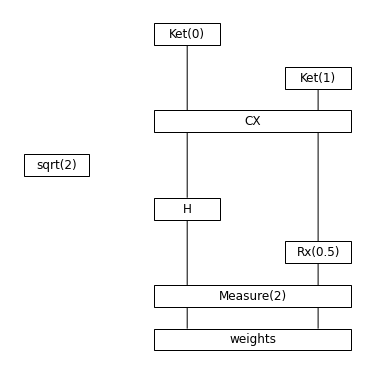

In [11]:
from discopy.quantum import bit, qubit, BitsAndQubits, CQCircuit

ob = {s: Ty(), n: qubit}
ar = lambda params: {
    Alice: Ket(0), Bob: Ket(1),
    love_box: verb_ansatz(params)}

F = lambda params: Functor(ob, ar(params), ob_factory=BitsAndQubits, ar_factory=CQCircuit)

print("Circuit for 'Alice loves Bob':")
F(params0)(diagrams['Alice loves Bob.']).draw(
    aspect='auto', draw_types=False, figsize=(5, 5))

In [12]:
from jax import jit

@jit
def corpus(params):
    return {sentence: F(params)(diagrams[sentence]).eval().array.real for sentence in sentences}

print(corpus(params0))

Exception: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(complex64[4]):JaxprTrace(level=-1/1)>.

This error can occur when a JAX Tracer object is passed to a raw numpy function, or a method on a numpy.ndarray object. You might want to check that you are using `jnp` together with `import jax.numpy as jnp` rather than using `np` via `import numpy as np`. If this error arises on a line that involves array indexing, like `x[idx]`, it may be that the array being indexed `x` is a raw numpy.ndarray while the indices `idx` are a JAX Tracer instance; in that case, you can instead write `jax.device_put(x)[idx]`.

In [ ]:
evaluate = lambda F, sentence: F(diagrams[sentence]).eval().array.real
corpus = {sentence: evaluate(F(params0), sentence) for sentence in sentences}

epsilon = 1e-2

print("True sentences:\n{}\n".format('\n'.join(sentence
    for sentence, probability in corpus.items() if probability > 1 - epsilon)))
print("False sentences:\n{}".format('\n'.join(sentence
    for sentence, probability in corpus.items() if probability < epsilon)))

In [ ]:
import jax.numpy as np
from jax import grad

def mean_squared(y_true, y_pred):
    return np.mean((np.array(y_true) - np.array(y_pred)) ** 2)

f = lambda params: mean_squared(*zip(*[
    (corpus[sentence], evaluate(F(params), sentence))
     for sentence in sentences]))

grad(f)([0.75] + 4 * [0.25])

In [ ]:
from jax import vmap

x = np.arange(0.0, 1.0, 0.01)
y = vmap(f)(x)
dy = vmap(grad(f))(x)

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 5)

plt.subplot(2, 1, 1)
plt.plot(x, y)
plt.title("functorial landscape for 'loves'")
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(x, dy)
plt.xlabel('phase')
plt.ylabel('grad')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

sentence_train, sentence_test = train_test_split(sentences, test_size=0.25, random_state=42)

print("Training set:\n{}\n".format('\n'.join(sentence_train)))
print("Testing set:\n{}".format('\n'.join(map(
    lambda x: 'Does ' + x.replace('loves', 'love').replace('.', '?'), sentence_test))))

In [ ]:
from jax import jit
from time import time

loss = {sentence: lambda params: mean_squared(corpus[sentence], evaluate(F(params), sentence))
                 for sentence in sentences}

@jit
def testing_loss(params):
    return np.mean(np.array([loss[sentence](params) for sentence in sentence_test]))

start = time()
print("{1:.3f} seconds to compile the testing loss of params0 ({0})".format(
    testing_loss(params0), time() - start))

step_size = 1e-2

@jit
def update(params):
    for sentence in sentence_train:
        params = {word: phase - step_size * grad(loss[sentence])(params)[word]
                  for word, phase in params.items()}
    return params

start = time()
print("{1:.3f} seconds to compile the update function just in time:\n{0}".format(
    update(params0), time() - start))

In [ ]:
from random import random, seed; seed(420)

print("Random parameter initialisation...")

params = {'loves': random()}
print("Initial parameters: {}".format(params))

print("Initial testing loss: {:.5f}\n".format(testing_loss(params)))

epochs, iterations = 7, 10

for epoch in range(epochs):
    start = time()
    for i in range(iterations):
        params = update(params)

    print("Epoch {} ({:.3f} milliseconds)".format(epoch, 1e3 * (time() - start)))
    print("Testing loss: {:.5f}".format(testing_loss(params)))
    print("params['loves'] = {:.3f}\n".format(params['loves']))

In [ ]:
print("Does Alice love Bob?")
print("Yes" if evaluate(F(params), 'Alice loves Bob.') > 1 - epsilon else "No")